In [1]:
# Core Libraries
import os
import pickle
import warnings

# Data Handling & Numerics
import numpy as np
import pandas as pd

# Image Processing
import cv2 # OpenCV for some image ops if needed, main loading via Keras
from PIL import Image # For basic image info

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for Machine Learning
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score

# TensorFlow / Keras for CNN Feature Extraction
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator # For data augmentation (conceptual)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

In [2]:
# Define the dataset path 
dataset_path = r"..//PlantVillage"

# Image dimensions for CNN model
IMG_WIDTH, IMG_HEIGHT = 224, 224

# Random state for reproducibility
RANDOM_STATE = 42

In [3]:
data_paths = []
labels = []

# Iterate through the dataset directory
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):  # Ensure it's a directory
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            # Basic check if it's an image file (can be more robust)
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                data_paths.append(img_path)
                labels.append(class_name)
            else:
                print(f"Skipping non-image file: {img_path}")


# Create the DataFrame
df = pd.DataFrame({'image_path': data_paths, 'label': labels})

print(f"Total images found: {len(df)}")
print(f"Number of unique classes: {df['label'].nunique()}")
print("\nFirst 5 entries in DataFrame:")
print(df.head())

if len(df) == 0:
    raise FileNotFoundError(f"No images found. Check your dataset_path: {dataset_path}")

Skipping non-image file: ..//PlantVillage\Tomato__Tomato_YellowLeaf__Curl_Virus\svn-r6Yb5c
Total images found: 20638
Number of unique classes: 15

First 5 entries in DataFrame:
                                          image_path  \
0  ..//PlantVillage\Pepper__bell___Bacterial_spot...   
1  ..//PlantVillage\Pepper__bell___Bacterial_spot...   
2  ..//PlantVillage\Pepper__bell___Bacterial_spot...   
3  ..//PlantVillage\Pepper__bell___Bacterial_spot...   
4  ..//PlantVillage\Pepper__bell___Bacterial_spot...   

                           label  
0  Pepper__bell___Bacterial_spot  
1  Pepper__bell___Bacterial_spot  
2  Pepper__bell___Bacterial_spot  
3  Pepper__bell___Bacterial_spot  
4  Pepper__bell___Bacterial_spot  


[INFO] Displaying Class Distribution...


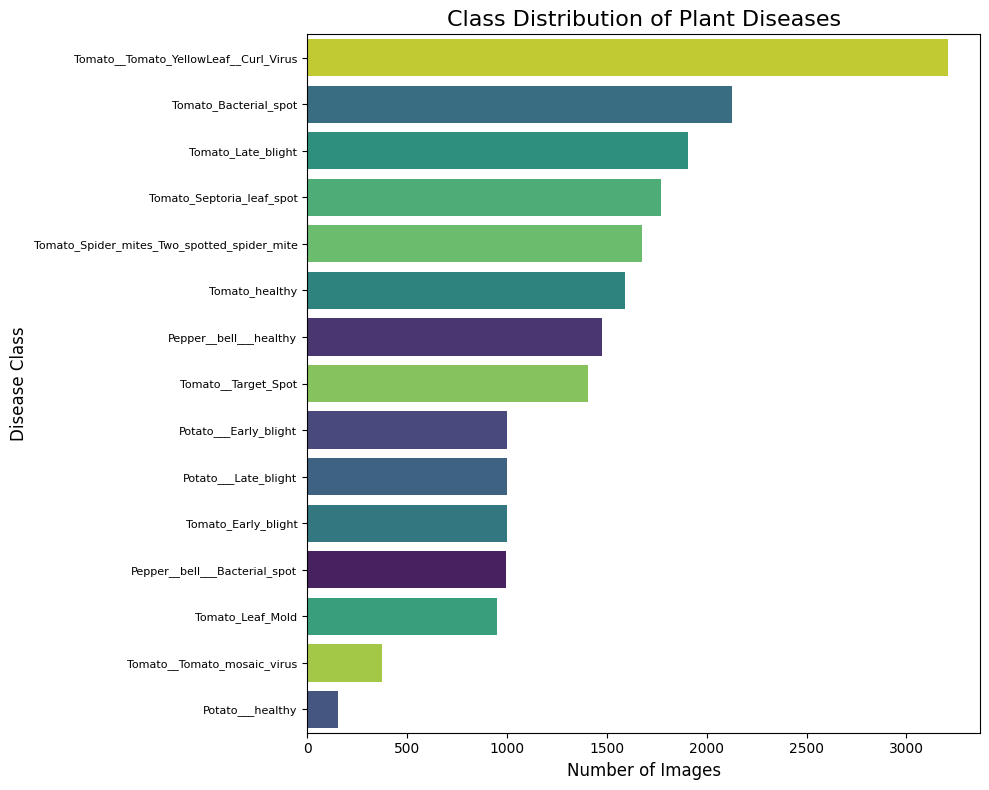


[INFO] Displaying a few random sample images from the dataset...


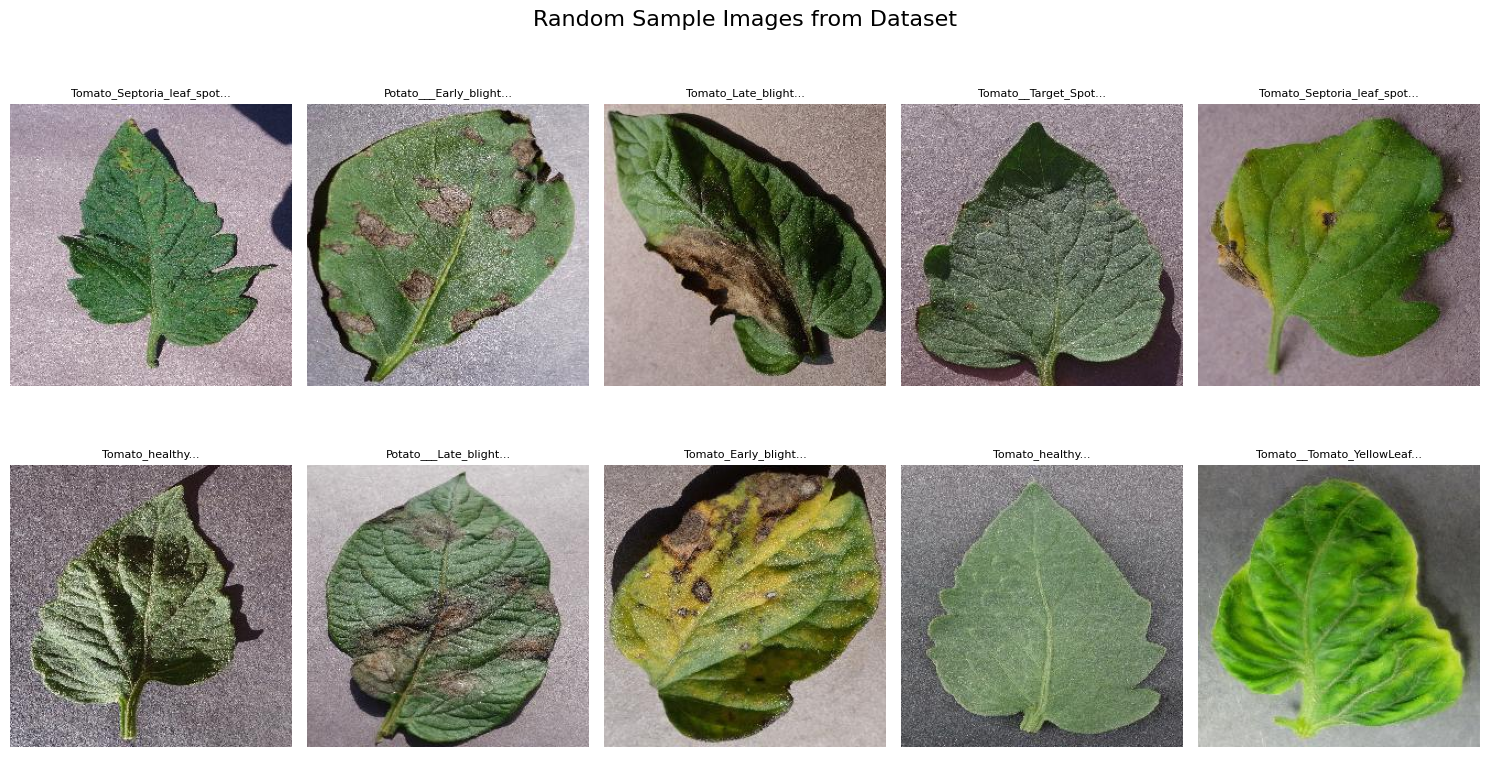

In [4]:
# 1. Class Distribution
print("[INFO] Displaying Class Distribution...")
plt.figure(figsize=(10, 8))
sns.countplot(data=df, y='label', order=df['label'].value_counts().index, 
              hue='label', palette="viridis", legend=False)
plt.title('Class Distribution of Plant Diseases', fontsize=16)
plt.xlabel('Number of Images', fontsize=12)
plt.ylabel('Disease Class', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=8) 
plt.tight_layout()
plt.show()

# 2. Display Sample Images
print("\n[INFO] Displaying a few random sample images from the dataset...")
# Take a random sample of images from the entire dataset
num_samples_to_show = 10 # Show 10 random samples

if num_samples_to_show > 0:
    sample_df_overall = df.sample(n=num_samples_to_show, random_state=RANDOM_STATE)

    plt.figure(figsize=(15, 8)) # Adjust figsize as needed (e.g., 2 rows of 5)
    for i, (index, row) in enumerate(sample_df_overall.iterrows()):
        plt.subplot(2, 5, i + 1) # Creates a 2x5 grid for 10 images
        img_path = row['image_path']
        label = row['label']
        try:
            img = Image.open(img_path)
            plt.imshow(img)
            plt.title(f"{label[:25]}...", fontsize=8) # Truncate long labels
            plt.axis('off')
        except Exception as e:
            print(f"Could not load image {img_path}: {e}")
            plt.title(f"Error loading {label[:15]}...", fontsize=8) # Fallback title
            plt.axis('off')
    plt.tight_layout()
    plt.suptitle("Random Sample Images from Dataset", fontsize=16, y=1.02)
    plt.show()
else:
    print("No images available in DataFrame to display samples.")

In [5]:
# Load pre-trained MobileNetV2 model + higher level layers
# include_top=False removes the final classification layer
base_model = MobileNetV2(weights='imagenet', include_top=False,
                         input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

# Add a global spatial average pooling layer to get a flat feature vector
x = base_model.output
x = GlobalAveragePooling2D()(x)
feature_extractor_model = Model(inputs=base_model.input, outputs=x)

print(f"Feature extractor output shape: {feature_extractor_model.output_shape}")


def extract_cnn_features(img_path_local):
    try:
        img = load_img(img_path_local, target_size=(IMG_WIDTH, IMG_HEIGHT))
        img_array = img_to_array(img)
        img_array_expanded_dims = np.expand_dims(img_array, axis=0)
        img_preprocessed = mobilenet_preprocess_input(img_array_expanded_dims)
        features = feature_extractor_model.predict(img_preprocessed, verbose=0)
        return features.flatten()
    except Exception as e:
        print(f"Error processing image {img_path_local}: {e}")
        return None

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Feature extractor output shape: (None, 1280)


In [6]:
# Shuffle DataFrame before feature extraction
df_shuffled = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

features_list = []
labels_list = [] # To store labels corresponding to successfully extracted features
print(f"\nStarting CNN feature extraction for {len(df_shuffled)} images...")

for index, row in df_shuffled.iterrows():
    img_path = row['image_path']
    label = row['label']
    
    cnn_features = extract_cnn_features(img_path)
    
    if cnn_features is not None:
        features_list.append(cnn_features)
        labels_list.append(label) # Only add label if features were extracted
    
    if (index + 1) % 200 == 0 or (index + 1) == len(df_shuffled): # Print progress
        print(f"Processed {index + 1}/{len(df_shuffled)} images...")

print(f"\nSuccessfully extracted features for {len(features_list)} out of {len(df_shuffled)} images.")

if not features_list:
    raise ValueError("No features were extracted. Check image paths, file integrity, and feature extraction function.")

features_array = np.array(features_list)
# Use labels_list here because it only contains labels for which features were extracted
labels_array = np.array(labels_list) 

print("\nShape of extracted CNN features array:", features_array.shape)
print("Shape of corresponding labels array:", labels_array.shape)


Starting CNN feature extraction for 20638 images...
Processed 200/20638 images...
Processed 400/20638 images...
Processed 600/20638 images...
Processed 800/20638 images...
Processed 1000/20638 images...
Processed 1200/20638 images...
Processed 1400/20638 images...
Processed 1600/20638 images...
Processed 1800/20638 images...
Processed 2000/20638 images...
Processed 2200/20638 images...
Processed 2400/20638 images...
Processed 2600/20638 images...
Processed 2800/20638 images...
Processed 3000/20638 images...
Processed 3200/20638 images...
Processed 3400/20638 images...
Processed 3600/20638 images...
Processed 3800/20638 images...
Processed 4000/20638 images...
Processed 4200/20638 images...
Processed 4400/20638 images...
Processed 4600/20638 images...
Processed 4800/20638 images...
Processed 5000/20638 images...
Processed 5200/20638 images...
Processed 5400/20638 images...
Processed 5600/20638 images...
Processed 5800/20638 images...
Processed 6000/20638 images...
Processed 6200/20638 

In [7]:
# Encode string labels into numeric form
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels_array)

print("\nSample of encoded labels:", labels_encoded[:10])
print("Mapping of encoded labels to original class names:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{i}: {class_name}")
print(f"Total unique encoded labels: {np.unique(labels_encoded).shape[0]}")

# Save the label encoder
with open(os.path.join('../models', 'label_encoder.pkl'), 'wb') as le_file:
    pickle.dump(label_encoder, le_file)
print("\nLabelEncoder saved to label_encoder.pkl")


Sample of encoded labels: [ 9  2  7 11  9 14  3  6 14 12]
Mapping of encoded labels to original class names:
0: Pepper__bell___Bacterial_spot
1: Pepper__bell___healthy
2: Potato___Early_blight
3: Potato___Late_blight
4: Potato___healthy
5: Tomato_Bacterial_spot
6: Tomato_Early_blight
7: Tomato_Late_blight
8: Tomato_Leaf_Mold
9: Tomato_Septoria_leaf_spot
10: Tomato_Spider_mites_Two_spotted_spider_mite
11: Tomato__Target_Spot
12: Tomato__Tomato_YellowLeaf__Curl_Virus
13: Tomato__Tomato_mosaic_virus
14: Tomato_healthy
Total unique encoded labels: 15

LabelEncoder saved to label_encoder.pkl


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    features_array, labels_encoded, 
    test_size=0.25,  # 25% for testing
    random_state=RANDOM_STATE,
    stratify=labels_encoded  # Important for imbalanced datasets
)

print("\nData Split:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"Class distribution in y_train: {np.bincount(y_train)}")
print(f"Class distribution in y_test: {np.bincount(y_test)}")


Data Split:
X_train shape: (15478, 1280), y_train shape: (15478,)
X_test shape: (5160, 1280), y_test shape: (5160,)
Class distribution in y_train: [ 748 1108  750  750  114 1595  750 1432  714 1328 1257 1053 2406  280
 1193]
Class distribution in y_test: [249 370 250 250  38 532 250 477 238 443 419 351 802  93 398]


In [9]:
print("\n[INFO] Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler
with open(os.path.join('../models','scaler.pkl'), 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)
print("StandardScaler saved to scaler.pkl")

print("X_train_scaled mean :", X_train_scaled.mean(axis=0)[:5])
print("X_train_scaled std :", X_train_scaled.std(axis=0)[:5])


[INFO] Scaling features...
StandardScaler saved to scaler.pkl
X_train_scaled mean : [-4.3918664e-07  1.6324078e-08  2.7226053e-08 -1.0081341e-07
 -1.6951780e-08]
X_train_scaled std : [0.99996483 0.99999976 1.0000068  0.9999865  1.0000037 ]



[INFO] Performing PCA to determine optimal number of components...


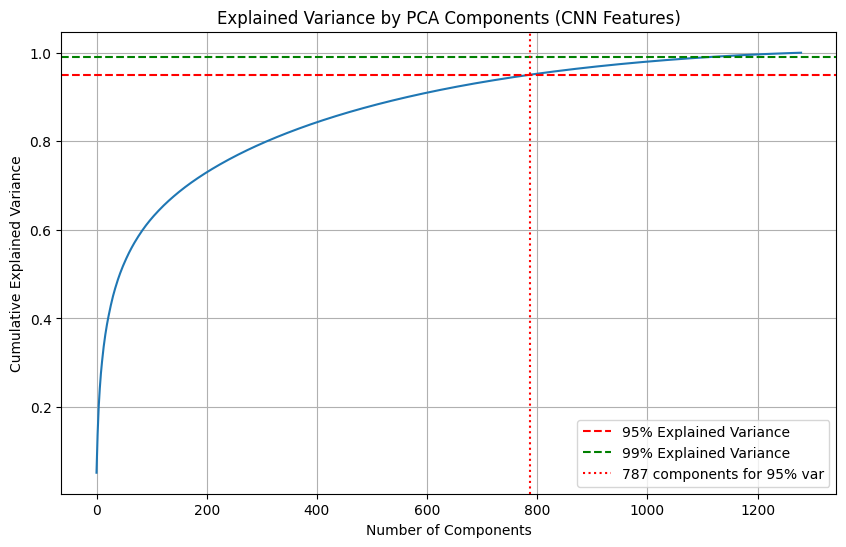

Number of components to explain ~95% variance: 787


In [10]:
print("\n[INFO] Performing PCA to determine optimal number of components...")
# Fit PCA with all components to see explained variance
pca_explorer = PCA(random_state=RANDOM_STATE)
pca_explorer.fit(X_train_scaled)

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_explorer.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components (CNN Features)')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.axhline(y=0.99, color='g', linestyle='--', label='99% Explained Variance')
# Find number of components for 95% variance
components_95_var = np.argmax(np.cumsum(pca_explorer.explained_variance_ratio_) >= 0.95) + 1
plt.axvline(x=components_95_var, color='r', linestyle=':', label=f'{components_95_var} components for 95% var')
plt.legend(loc="best")
plt.show()

print(f"Number of components to explain ~95% variance: {components_95_var}")

In [11]:
N_COMPONENTS = components_95_var 

print(f"\n[INFO] Applying PCA with n_components = {N_COMPONENTS}...")
pca = PCA(n_components=N_COMPONENTS, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Save the PCA model
with open(os.path.join('../models','pca_model.pkl'), 'wb') as pca_file:
    pickle.dump(pca, pca_file)
print("PCA model saved to pca_model.pkl")

print(f"Original feature space dimension: {X_train_scaled.shape[1]}")
print(f"Reduced feature space dimension (PCA): {X_train_pca.shape[1]}")
print(f"Total variance explained by {pca.n_components_} components: {np.sum(pca.explained_variance_ratio_):.4f}")


[INFO] Applying PCA with n_components = 787...
PCA model saved to pca_model.pkl
Original feature space dimension: 1280
Reduced feature space dimension (PCA): 787
Total variance explained by 787 components: 0.9488


In [12]:
print("\n[INFO] Hyperparameter tuning for KNN with GridSearchCV...")

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11], # Common choices for k
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'cosine']
}

# Using StratifiedKFold for cross-validation, good for classification
cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# n_jobs=-1 uses all available CPU cores
grid_search_knn = GridSearchCV(KNeighborsClassifier(n_jobs=-1), 
                               param_grid, 
                               cv=cv_stratified,
                               verbose=2, # Shows progress
                               scoring='accuracy') # Use accuracy for scoring

grid_search_knn.fit(X_train_pca, y_train) # Use PCA-transformed training data

print("\nBest Parameters found by GridSearchCV:", grid_search_knn.best_params_)
print("Best Cross-Validation Score (Accuracy):", grid_search_knn.best_score_)

# Get the best KNN model
best_knn_model = grid_search_knn.best_estimator_

# Save the best KNN model
with open(os.path.join('../models','best_knn_model.pkl'), 'wb') as model_file:
    pickle.dump(best_knn_model, model_file)
print("Best KNN model saved to best_knn_model.pkl")


[INFO] Hyperparameter tuning for KNN with GridSearchCV...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   3.2s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.4s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.4s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.4s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.4s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.3s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.3s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.3s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.4s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.3s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total t

In [13]:
print("\n[INFO] Evaluating the best KNN model on the test set...")
y_pred_test = best_knn_model.predict(X_test_pca)

test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"\nTest Set Accuracy: {test_accuracy:.4f}")

print("\nClassification Report on Test Set:")
# Use label_encoder.classes_ to get original string label names
class_report = classification_report(y_test, y_pred_test, 
                                     target_names=label_encoder.classes_, 
                                     digits=4)
print(class_report)


[INFO] Evaluating the best KNN model on the test set...

Test Set Accuracy: 0.8841

Classification Report on Test Set:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot     0.9619    0.9116    0.9361       249
                     Pepper__bell___healthy     0.9407    0.9865    0.9631       370
                      Potato___Early_blight     0.8893    0.9960    0.9396       250
                       Potato___Late_blight     0.9469    0.8560    0.8992       250
                           Potato___healthy     0.8974    0.9211    0.9091        38
                      Tomato_Bacterial_spot     0.8725    0.9774    0.9220       532
                        Tomato_Early_blight     0.8951    0.5120    0.6514       250
                         Tomato_Late_blight     0.8965    0.8532    0.8743       477
                           Tomato_Leaf_Mold     0.8604    0.8025    0.8304       238
                  Tomato_Sept

<Figure size 1500x1500 with 0 Axes>

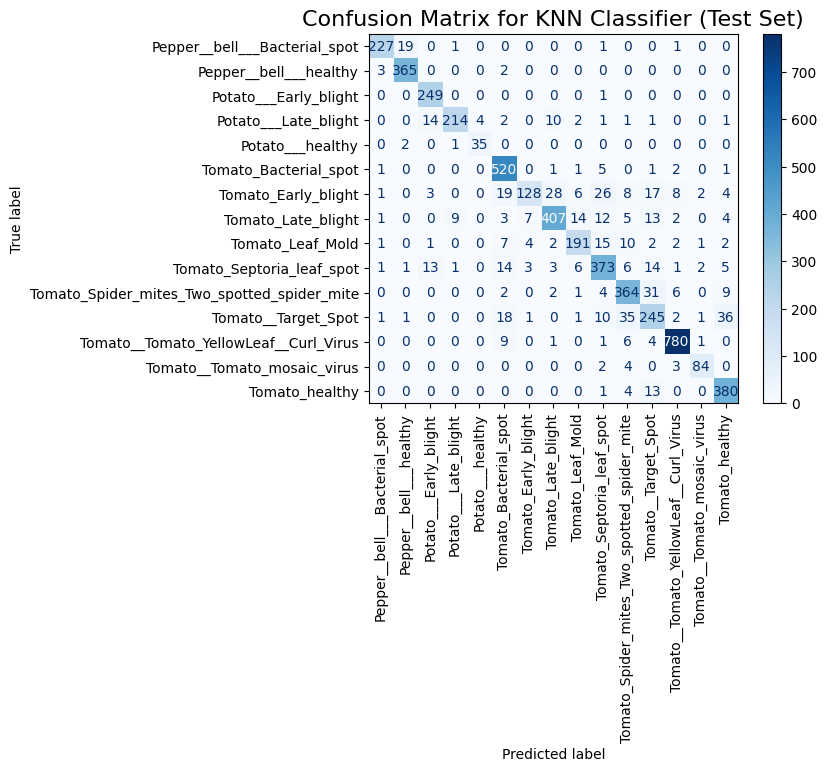

In [14]:
# 1. Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# 2. Plot the confusion matrix using ConfusionMatrixDisplay
plt.figure(figsize=(15, 15)) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_encoder.classes_)

disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', values_format='d') 

plt.title('Confusion Matrix for KNN Classifier (Test Set)', fontsize=16)
plt.show()